In [1]:
import os
import sys
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, clear_border
from skimage.measure import regionprops



sys.path.append("code/preprocessing/utils/")
from segment2D import *
from segment3D import *
from file_handling import *

In [2]:
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

In [3]:
path = "data/experimental/raw/tomocube_20250904_B1"
#path = "data/experimental/raw/holomonitor_20240301_B1-4"

fmin=0
fmax=40

#path = "data_tmp/Well_A2-1_zero_corr"
# #mask = imageio.v2.imread(f"data/experimental/raw/holomonitor_20240516_A2-1/mask.tiff")
# im = []
# for f in range(1, 200):

#     #frame = imageio.v2.imread(f"{path}/MDCK-li_reg_zero_corr_fluct_{f}.tiff")
#     frame = imageio.v2.imread(f"{path}/Well A2-1 _reg__Zc0fluct_{f}.tiff")# * (mask > 0)
#     im.append(frame / 100)

# import data
microscope = Path(path).stem.split("_")[0]

if microscope == 'holomonitor':
    pix_to_um = get_pixel_size()
    im = import_holomonitor_stack(path, 
                                    f_min=fmin,
                                    f_max=fmax)

elif microscope == 'tomocube':
    pix_to_um = get_voxel_size_35mm()
    im, h_im = import_tomocube_stack(path, 
                                       h_scaling=vox_to_um[0], 
                                       f_min=fmin, 
                                       f_max=fmax)

# # Tomocube
# fmin = 1
# fmax = 40
# file = "250611.151310.MDCK-parental.001.1per7_5.B3.T001P02"
# folder = "../data/Tomocube/MDCK_11.06.2025/B3P2"
# im, _ = import_tomocube_stack(folder, file, vox_to_um[0], f_min=fmin, f_max=fmax)



(41, 3648, 3648)


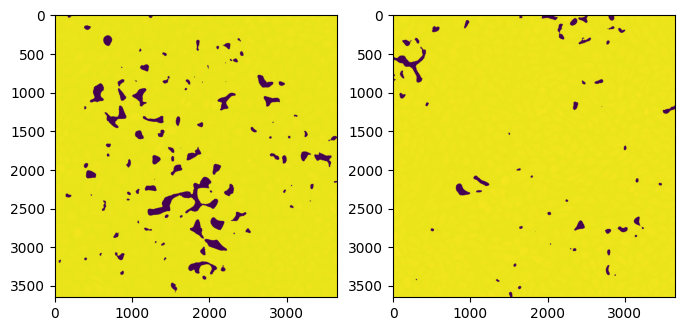

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(im[0])
ax[1].imshow(im[-1])

# im = im[:, 100:, :3200]
# h_im = h_im[:, 100:, :3200]
print(np.shape(im))

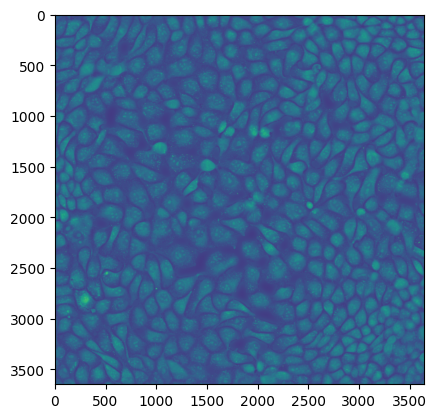

In [13]:
idx = 0

if microscope == 'holomonitor':
    s_high_tmp = 6
    s_low_tmp  = 12
    r0 = 13

if microscope == 'tomocube':
    s_high_tmp = 20
    s_low_tmp  = 1.1*s_high_tmp
    r0 = 12 # times 


im_blur = np.copy(im[idx])
im_tmp  = np.copy(im[idx])
im_blur[im_blur < 1.33] = 1.37#np.mean(im_blur)
im_blur = sc.ndimage.gaussian_filter(im_blur, 40)

im_tmp[im_tmp < 1.33] = im_blur[im_tmp < 1.33]
plt.imshow(im_tmp)

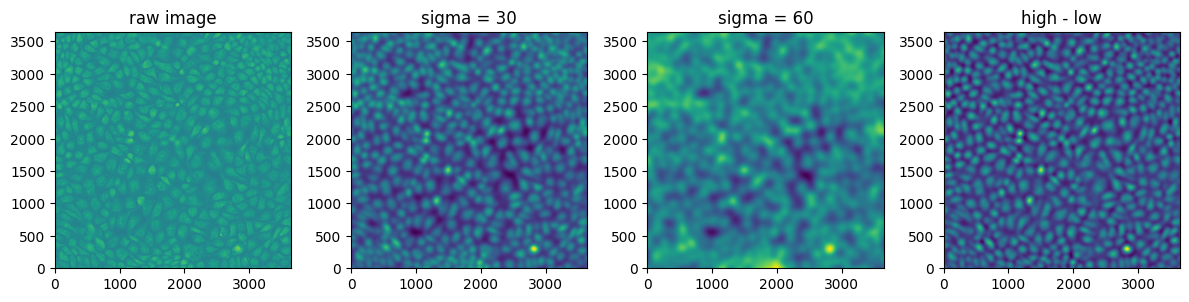

In [14]:

r0 = 40
tau = 10
s_high_tmp = 30
s_low_tmp  = 60

def particle_size(frame, r0, tau):
    return r0 * 2 ** (-frame / (2*tau))

n_norm    = smoothen_normalize_im(im_tmp, s_high_tmp, s_low_tmp, fig=False)
positions1 = peak_local_max(n_norm, min_distance=int(np.round(particle_size(idx, r0, tau*4))))

n_norm    = smoothen_normalize_im(im_tmp, 30, 60, fig=True)
positions2 = peak_local_max(n_norm, min_distance=int(np.round(particle_size(idx, 40, 10*4))))

445
445


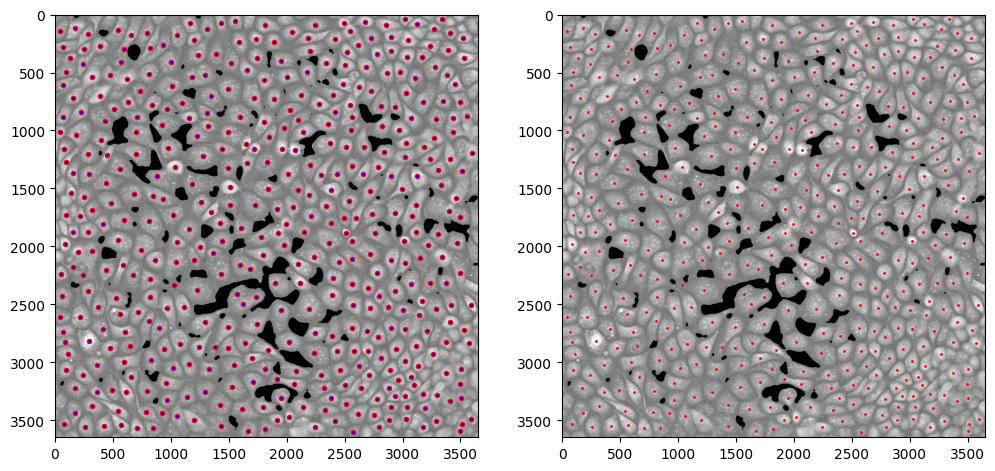

In [15]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(im[idx], cmap="gray", vmin=1.35, vmax=1.4)
ax[0].plot(positions2.T[1], positions2.T[0], 'r.', ms=6)
ax[0].plot(positions1.T[1], positions1.T[0], 'b.', ms=2)

ax[1].imshow(im[idx], cmap="gray", vmin=1.35, vmax=1.4)
ax[1].plot(positions2.T[1], positions2.T[0], 'r.', ms=2)
print(len(positions1))
print(len(positions2))

In [16]:
def get_cell_areas(im, pos, h_im, clear_edge=True):
    '''
    Uses watershed to obtain mask of labeled cell areas
    '''

    # get cell areas with watershed
    seeds = generate_seed_mask(pos, im.shape)
    areas = watershed(im, seeds, watershed_line=False, connectivity=1)


    # remove empty areas
    cell_mask = (h_im > 0)
    cell_areas = areas*cell_mask

    # remove small holes and areas
    #cell_areas = morph.remove_small_holes(cell_areas, area_threshold=100)

    if clear_edge:
        cell_areas = clear_border(cell_areas)

    return cell_areas

In [17]:
test = smoothen_normalize_im(im_tmp, 20, 30)

areas1 = get_cell_areas(-n_norm, positions1, im[idx], clear_edge=True)
areas2 = get_cell_areas(-test, positions2, im[idx], clear_edge=True)

# reg1 = regionprops(areas1, im[idx])
# reg2 = regionprops(areas2, im[idx])

# pos1 = np.array([cell.centroid_weighted for cell in reg1])
# pos2 = np.array([cell.centroid_weighted for cell in reg2])


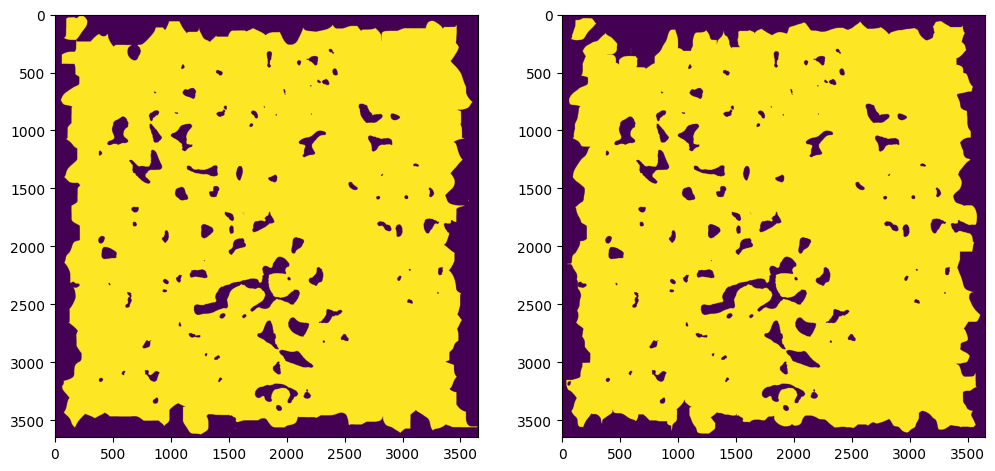

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(areas1 >0)
ax[1].imshow(areas2>0)

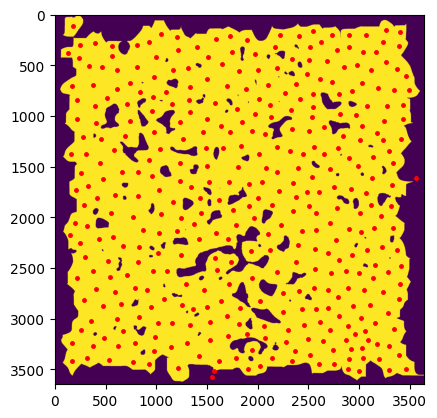

In [19]:
cellprops = regionprops(areas1, im[idx])
positions = np.array([cell.centroid_weighted for cell in cellprops])
plt.imshow(areas1 >0)
plt.plot(positions.T[1], positions.T[0], 'r.', ms=5)


In [ ]:
new_pos = []
wrong_pos = []
for x, y in pos_idx:
    if im[idx, x, y] < 1.33:
        wrong_pos.append([int(x), int(y)])
        continue
    else:
        new_pos.append([int(x), int(y)])

new_pos = np.array(new_pos)
wrong_pos = np.array(wrong_pos)

In [136]:
r0 = 13

def particle_size(frame, r0, tau):
    return int(r0 * 2 ** (-frame / (2*tau)))

particle_size(12*12, r0, 16*12)

10